### Download the pretrained model

In [3]:
! python -m spacy download en_core_web_lg # de_core_news_lg

  Using cached en_core_web_lg-2.3.1-py3-none-any.whl
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [4]:
! python --version

Python 3.9.1


### Get the data for a specific topic from Wikipedia API

In [3]:
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm

def wiki_scrape(topic_name, verbose=True):
    def wiki_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                return {'page': link, 'text': page.text, 'link': page.fullurl,
                        'categories': list(page.categories.keys())}
        except:
            return None

    wiki_api = wikipediaapi.Wikipedia(language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(topic_name)
    if not page_name.exists():
        print('Page {} does not exist.'.format(topic_name))
        return
    
    page_links = list(page_name.links.keys())
    progress = tqdm(desc='Links Scraped', unit='', total=len(page_links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl,
                'categories': list(page_name.categories.keys())}]
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        future_link = {executor.submit(wiki_link, link): link for link in page_links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            sources.append(data) if data else None
            progress.update(1) if verbose else None     
    progress.close() if verbose else None
    
    namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki',
                  'Template', 'Help', 'User', 'Category talk', 'Portal talk')
    sources = pd.DataFrame(sources)
    sources = sources[(len(sources['text']) > 20)
                      & ~(sources['page'].str.startswith(namespaces, na=True))]
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    sources['topic'] = topic_name
    print('Wikipedia pages scraped:', len(sources))
    
    return sources


In [4]:
wiki_data = wiki_scrape("Facebook")

Links Scraped: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 958/958 [00:22<00:00, 43.50/s]

Wikipedia pages scraped: 169


In [6]:
wiki_data[:100]

,page,text,link,categories,topic
0,Facebook,Facebook is an online social media and social ...,https://en.wikipedia.org/wiki/Facebook,"[2004 establishments in Massachusetts, All Wik...",Facebook
1,2015 Rohingya refugee crisis,"In 2015, tens of thousands of Rohingya people ...",https://en.wikipedia.org/wiki/2015_Rohingya_re...,"[2015 in Bangladesh, 2015 in Myanmar, 2015 in ...",Facebook
2,2018 United States elections,The 2018 United States elections were held on ...,https://en.wikipedia.org/wiki/2018_United_Stat...,"[2018 elections in the United States, 2018 ele...",Facebook
3,2016 United States presidential election,The 2016 United States presidential election w...,https://en.wikipedia.org/wiki/2016_United_Stat...,"[2016 United States presidential election, 201...",Facebook
4,2017 United States Senate special election in ...,The 2017 United States Senate special election...,https://en.wikipedia.org/wiki/2017_United_Stat...,"[2017 Alabama elections, 2017 United States Se...",Facebook
...,...,...,...,...,...
95,Bing (search engine),Microsoft Bing (commonly known as Bing) is a w...,https://en.wikipedia.org/wiki/Microsoft_Bing,"[2009 establishments in the United States, All...",Facebook
96,Binary number,A binary number is a number expressed in the b...,https://en.wikipedia.org/wiki/Binary_number,"[Articles with GND identifiers, Articles with ...",Facebook
97,BitTorrent,BitTorrent is a communication protocol for pee...,https://en.wikipedia.org/wiki/BitTorrent,"[All Wikipedia articles in need of updating, A...",Facebook
98,BlackBerry Limited,BlackBerry Limited is a Canadian software comp...,https://en.wikipedia.org/wiki/BlackBerry_Limited,"[1984 establishments in Ontario, 1998 initial ...",Facebook


In [7]:
#wiki_data = pd.read_csv("data.csv")

In [8]:
def wiki_page(page_name):
    wiki_api = wikipediaapi.Wikipedia(language='en',
            extract_format=wikipediaapi.ExtractFormat.WIKI)
    page_name = wiki_api.page(page_name)
    if not page_name.exists():
        print('Page {} does not exist.'.format(page_name))
        return

    page_data = pd.DataFrame({
        'page': page_name,
        'text': page_name.text,
        'link': page_name.fullurl,
        'categories': [[y[9:] for y in
                       list(page_name.categories.keys())]],
        })

    return page_data

### Extract relevant information using NER

In [9]:
import pandas as pd
import re
import spacy
import neuralcoref

nlp = spacy.load('en_core_web_lg')
neuralcoref.add_to_pipe(nlp)

def get_entity_pairs(text, coref=True):
    # preprocess text
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)
    if coref:
        text = nlp(text._.coref_resolved)  # resolve coreference clusters

    def refine_ent(ent, sent):
        unwanted_tokens = (
            'PRON',  # pronouns
            'PART',  # particle
            'DET',  # determiner
            'SCONJ',  # subordinating conjunction
            'PUNCT',  # punctuation
            'SYM',  # symbol
            'X',  # other
        )
        ent_type = ent.ent_type_  # get entity type
        if ent_type == '':
            ent_type = 'NOUN_CHUNK'
            ent = ' '.join(str(t.text) for t in
                           nlp(str(ent)) if t.pos_
                           not in unwanted_tokens and t.is_stop == False)
        elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
            refined = ''
            for i in range(len(sent) - ent.i):
                if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                    refined += ' ' + str(ent.nbor(i))
                else:
                    ent = refined.strip()
                    break

        return ent, ent_type

    sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    ent_pairs = []
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = spacy.util.filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag,
                                            'dep': span.root.dep}) for span in spans]
        deps = [token.dep_ for token in sent]

        # limit our example to simple sentences with one subject and object
        if (deps.count('obj') + deps.count('dobj')) != 1\
                or (deps.count('subj') + deps.count('nsubj')) != 1:
            continue

        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
                continue
            subject = [w for w in token.head.lefts if w.dep_
                       in ('subj', 'nsubj')]  # identify subject nodes
            if subject:
                subject = subject[0]
                # identify relationship by root dependency
                relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                if relation:
                    relation = relation[0]
                    # add adposition or particle to relationship
                    if relation.nbor(1).pos_ in ('ADP', 'PART'):
                        relation = ' '.join((str(relation), str(relation.nbor(1))))
                else:
                    relation = 'unknown'

                subject, subject_type = refine_ent(subject, sent)
                token, object_type = refine_ent(token, sent)

                ent_pairs.append([str(subject), str(relation), str(token),
                                  str(subject_type), str(object_type)])

    ent_pairs = [sublist for sublist in ent_pairs
                          if not any(str(ent) == '' for ent in sublist)]
    pairs = pd.DataFrame(ent_pairs, columns=['subject', 'relation', 'object',
                                             'subject_type', 'object_type'])
    print('Entity pairs extracted:', str(len(ent_pairs)))

    return pairs

### Get all the extracted pairs (RDFs) as a pandas dataframe

In [12]:
pairs = get_entity_pairs(wiki_data.loc[0,'text'])

Entity pairs extracted: 110


In [13]:
pairs

,subject,relation,object,subject_type,object_type
0,Facebook,claimed,2.93 billion monthly active users,ORG,NOUN_CHUNK
1,users,create,profile,NOUN_CHUNK,NOUN_CHUNK
2,Facemash,attracted,450 visitors,ORG,NOUN_CHUNK
3,Harvard,had,paper version,ORG,NOUN_CHUNK
4,Zuckerberg,told,The Harvard Crimson,PERSON,ORG
...,...,...,...,...,...
105,Facebook,removed,687 pages,ORG,NOUN_CHUNK
106,Collins English Dictionary,declared,"""Facebook",PERSON,ORG
107,service,includes,low bandwidth applications,NOUN_CHUNK,NOUN_CHUNK
108,Facebook,use,George Mason University,ORG,ORG


In [ ]:
# pairs.to_csv("./data/pairs.csv")

### Visualise  pairs as a knowledge graph

In [34]:
import networkx as nx
import matplotlib.pyplot as plt


def draw_kg(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object',
            create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(40, 40), dpi=50)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 300 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)),
                  pairs['relation'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,
                                 font_color='red')
    plt.axis('off')
    plt.show()

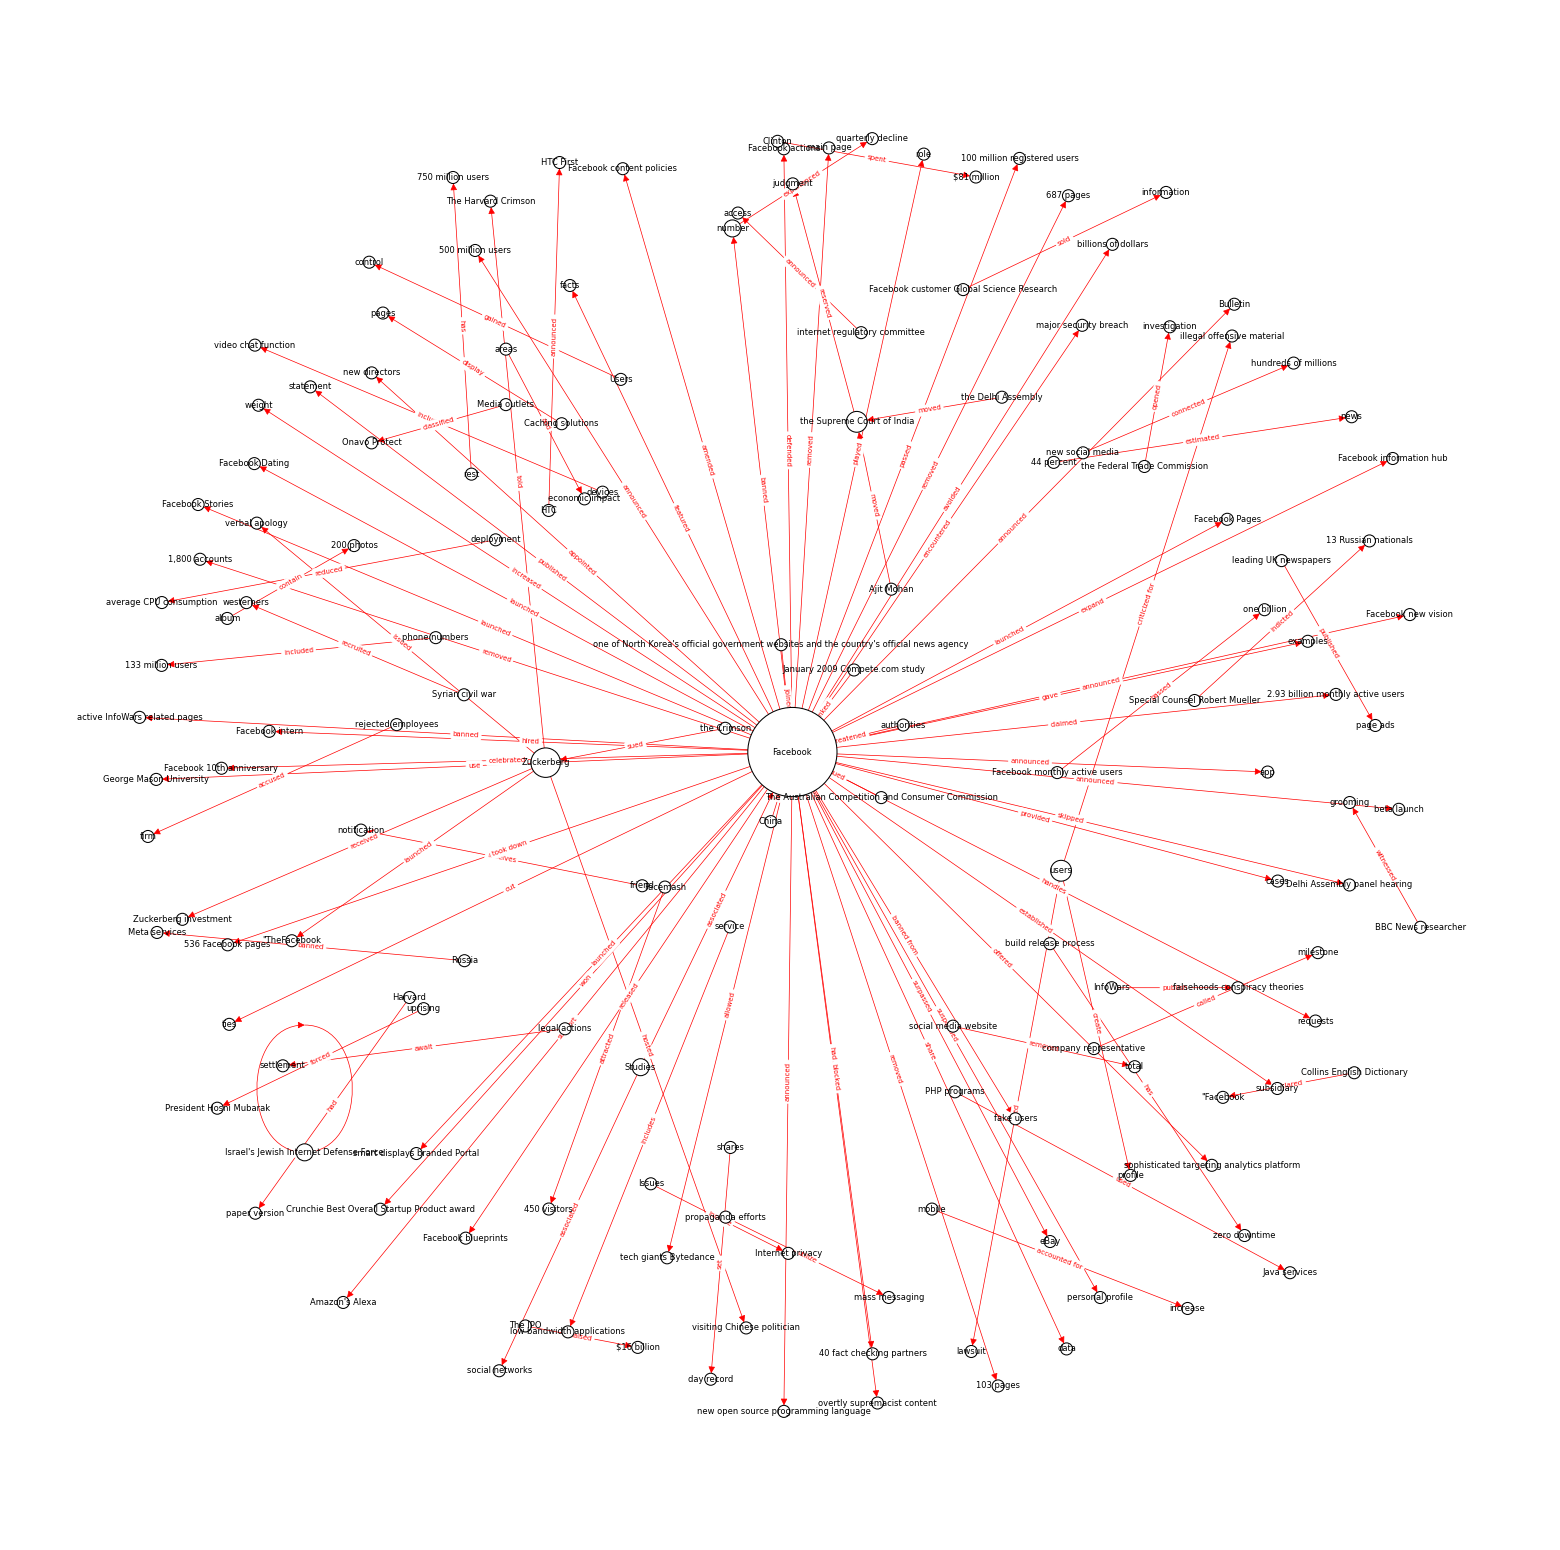

In [35]:
draw_kg(pairs)